<a href="https://colab.research.google.com/github/anthonyhu25/Variance-Reduction-Code/blob/main/Variance_Reduction_Example_2_(2_4_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import numpy as np
from numpy import random
from numpy import linalg
import math
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous, rv_discrete
from scipy.stats._distn_infrastructure import rv_frozen
from scipy.special import logsumexp
import scipy.integrate
import warnings
import sys
import statistics
import pandas as pd
from IPython.display import display, Math, HTML

# Example 2: Bayesian model selection in non-conjugate linear regression

Consider $y = Xβ + ϵ$, where $y = (y_{1} ,... , y_{N})$ a column vector of observations, $X$ is an $N \times p$ design matrix, $β = (\beta_{1},...,\beta_{p})$ is a column vector of regression coefficients, and $ϵ \sim N(0, \sigma^2 I_{n})$ is the error vector.

For Bayesian model selection, we seek to calculate posterior model probabilities $f(m|y) \propto f(m)f(y|m)$ for every $m$ specified by $β_{m}$, where we arrange $p$ elements from $β$ with $2^p$ possible sets (the power set) for each design matrix $X_{m}$. So, we need to calculate the marginal likelihood of y with respect to model m, given by $f(y|m) = ∫f(y|m, \beta_{m})f(\beta_{m}|m)dβ_{m}$, such that $f(y|m, \beta_{m})$ is the conditional likelihood function of y on $m$ and $\beta_{m}$, and $f(\beta_{m}|m)$ is the prior density of model $m$.

In this example, we seek to estimate the density of $f(y|m, β_{m})$ analytically. So, we are implicitly finding the expectation of $f(y|m, \beta_{m})$, or $E_{q}(f(y|m, \beta_{m})$ -- in this example, we set the function $F(x) = f(y|m, \beta_{m})$. To do so, note that we have two priors in this example: one on $g$ and one on $\beta_{m}|g, m$. Let N = 50 datapoints, with predictors $X_{i} \sim N(0,1), i = 1,...,4$ and response $Y \sim N(4X_{3} + 4X_{4}, 2.5 ^ 2)$. Suppose we choose a proposal density for $\beta_{m}$ in the form

$$
q(\beta_{m}) = \sum_{i=1}^{K} w_{i}N(\beta_{m}|0, g_{i}(X_{m}^{\top}X_{m})^{-1})
$$

such that $\sum_{i=1}^{K} w_{i} = 1, 0 < w_{i} < 1$

Note that the g-prior is defined as $p(g) = (1+g)^{-2}, g > 0$ in this example.

We will simulate the g-prior by using the Lomax distribution directly from [SciPy](https://scipy.github.io/devdocs/reference/generated/scipy.stats.lomax.html), given below as:

$f(x|c) = \frac{c}{(1+x)^{c+1}}$

So the g-prior is actually a Lomax distribution with shape parameter($c$) equal to 1.


The numbers for this example will be from the $X_{123}$ model, which means that the first three covariates $(1,2,3)$, denoted as $m$ in the paper, will be used in the model. However, I will run all of the possible covariates combinations for comparison of the algorithm.

In [78]:
# Initializing the X and Y matrices
## N and p are set from the paper
N = 50
p = 4
# Generate X first
mu = 0
sigma = 1
X_1 = np.random.normal(mu, sigma, size = N)
X_2 = np.random.normal(mu, sigma, size = N)
X_3 = np.random.normal(mu, sigma, size = N)
X_4 = np.random.normal(mu, sigma, size = N)
X = np.column_stack((X_1, X_2, X_3, X_4))
# Generate Y, note the distribution of Y is defined above
y = []
for i in range(len(X_1)):
  Y_i = np.random.normal(loc = 4 * X_3[i] + 4 * X_4[i], scale = 2.5)
  y.append(Y_i)

In [79]:
def beta_generation(N, g_prior_function, m):
  betas = []
  g = []
  for i in range(N):
    # If prior function is a scipy frozen RV. can directly sample from its RVs attribute call
    if isinstance(g_prior_function, rv_frozen):
      # Generate g prior first
      g_i = g_prior_function.rvs(size = 1)
      # Then generate beats
      beta_i = np.random.multivariate_normal(mean = [0 for i in range(len(m))],
                                           cov = g_i * np.identity(len(m)))
      betas.append(beta_i.tolist())
      g.append(g_i)
    else:
    # Otherwise, use a custom g prior function (used for clipping), and have to use correct function calls for that
      g_i = g_prior_function(size = 1)
      beta_i = np.random.multivariate_normal(mean = [0 for i in range(len(m))],
                                           cov = g_i * np.identity(len(m)))
      betas.append(beta_i.tolist())
      g.append(g_i)
    # sample beta from multivariate normal, with 0 mean and gI(m) covariance matrix

  # 1st element is the simulated betas, 2nd element is the simulated g values
  return betas, g

In [80]:
# Note that m is given as a string in this argument. This matches with the notation in the paper
# if m = "123", then variables 1, 2, and 3 are chosen as the data matrix
m = "123"
A = beta_generation(1000, scipy.stats.lomax(c=1), m)

# In this example, K(number of Gaussians to generate conditional distribution of Beta_m) is equal to 4
K = 4

It seems that we need further add assumptions to recover the $\hat\Sigma_{j}= \hat g_{i}I_{(m)}$ covariance structure in the EM algorithm. Although I can see that the $\hat\Sigma_{j}$ covariance matrices have similar diagonal elements and relatively small non-diagonal values, I still cannot infer what $\hat g_{i}$ is from each $\hat \Sigma_{j}$. We can still sample from the covariance matrices $\Sigma_{j}$, but the proposal density would now take the form of $q(\hatβ) = \sum_{j=1}^{K} \hat w_{j}N(\hatβ|0, \hat\Sigma_{j})$, and perform the same linear transformation $\beta_{m} = (X_{m}^{T}X_{m})^{-\frac{1}{2}}\hat β$ to obtain the estimates of the coefficients.

Here, I will derive the necessary steps for the M-step of this algorithm, from the joint log-likelihood of the EM algorithm, in order to enforce the $\hat g_{i}I_{(m)}$ structure.

Let $𝓛(g_{j})$ be the joint log-likelihood of the datapoints, conditional on the fact that the covariance matrix for the Gaussian is $g_{j}I_{(m)}$.

$$𝓛(g_{j}) = \sum_{i=1}^{N}r_{ij} log N(β_{i}|\mu_{j} = 0_{m}, g_{j}I_{(m)})$$

$$= \sum_{i=1}^{N} r_{ij} log[(2π)^{-m/2} |g_{j}I_{m}|^{-1/2}exp(-\frac{1}{2}\beta_{i}^{T}(g_{j}I_{m})^{-1}\beta_{i})]$$

$$ = \sum_{i=1}^{N} r_{ij} [-\frac{m}{2}log(2\pi g_{j}) - \frac{1}{2g_{j}}\beta_{i}^{T}\beta_{i}]$$

$$ = -\frac{m}{2}log(2\pi g_{j})(\sum_{i=1}^{N} r_{ij}) - \frac{1}{2g_{j}}\sum_{i=1}^{N}r_{ij}||\beta_{i}||^{2}$$

Note that the term $|g_{j}I_{m}|$ is equivalent to $g_{j}^{m}|I_{m}|$, due to the property of a determinant with a scalar of a matrix. Hence, the term $log[(2\pi)^{-\frac{m}{2}}|g_{j}I_{m}|^{-\frac{1}{2}}]$ can be simplified to $-\frac{m}{2}log(2\pi g_{j})$

Take derivative with respect to $g_{j}$ and set to $0$ to solve for $\hat g_{j}$

$$\frac{d𝓛(g_{j})}{dg_{j}} = -\frac{m}{2g_{j}}\sum_{i=1}^{N}r_{ij} + \frac{1}{2g_{j}^{2}}\sum_{i=1}^{N}r_{ij}||β_{i}||^{2} = 0$$

$$ -mg_{j}\sum_{i=1}^{N}r_{ij} + \sum_{i=1}^{N}r_{ij}||β_{i}||^{2} = 0$$

$$\hat g_{j} = \frac{\sum_{i=1}^{N}r_{ij}||β_{i}||^{2}}{m\sum_{i=1}^{N}r_{ij}}$$

Now, instead of updating $\Sigma_{j}$, we use this to update $g_{j}$ and maintain the diagonal structure of the $\Sigma_{j}$, as it was presented in the paper.

I will write a new EM algorithm below for the change. Note that I will also add some quality of life changes (sometimes depending on the values drawn from the priors I can have extremely small values for $g_{i}$ or $N(0, gI_{m})$. So I will use the log trick(adding log to the expression and then exponentiate to cancel out the log) for numerical stability purposes.

In [81]:
def EM_algorithm_Gaussians_diagonal_matrix(K, list_betas, p, g_sampler, N_iterations, update_mu, only_print_final = False,
                           init_means=None, init_covs=None):
    for i in range(len(list_betas)):
        if len(list_betas[i]) != p:
            warnings.warn("Dimensions of betas and p do not match.")
            sys.exit(1)
    w_i = np.random.dirichlet(np.ones(K)).tolist()
    initial_w_i = w_i.copy()
    g_i = [0 for _ in range(K)]
    # Log Likelihood list for convergence diagnostics -- should always be nondecreasing
    log_likelihoods_list = []
    if init_means is not None and len(init_means) == K:
        mu_list = init_means
    elif init_means is not None and len(init_means) != K:
        warnings.warn("Number of means and K do not match.")
        sys.exit(1)
    else:
        mu_list = [[0 for _ in range(p)] for _ in range(K)]
    if init_covs is not None:
        sigma_list = init_covs
    elif hasattr(g_sampler, "rvs"):
        g_i = g_sampler.rvs(size = K)
        sigma_list = [g * np.identity(p) for g in g_i]
    else:
        g_i = g_sampler(K)
        sigma_list = [g * np.identity(p) for g in g_i]
    # Initialize the initial g_i for comparison of algorithm
    initial_g_i = g_i.copy()
    for v in range(N_iterations):
      ## Adding total log_likelihood counter for measure of model performance
        ll_total = 0.0
        responsibilities = np.empty(shape=(len(list_betas), K))
        # E-step
        for i in range(len(list_betas)):
          # initiate beta
            beta_i = list_betas[i]
          # calculate likelihoods
          ## using log likelihood for numerical stability purposes
          ### Indeterminate values when calculating EM, especially when g is small, due to abnormally large or small PDFs, which can cause 0-near or
          ### super-large denominators. This in turn causes NAN values, which causes issues with the algorithm
            log_likelihoods = [
                math.log(w_i[j]) + scipy.stats.multivariate_normal.logpdf(
                    beta_i, mean=mu_list[j], cov=sigma_list[j], allow_singular=True
                )
                for j in range(K)
            ]
            denom = scipy.special.logsumexp(log_likelihoods)
            ll_total += denom
            for j in range(K):
              # Exponentiate to remove the log.
              responsibilities[i][j] = math.exp(log_likelihoods[j] - denom)
        # M-step
        for i in range(K):
            r_i = responsibilities[:, i]
            total_r_i = np.sum(r_i)
            if update_mu == True:
              # Calculate Mus
              mu_new = np.sum([
                  r_i[j] * np.array(list_betas[j]) for j in range(len(list_betas))
              ], axis=0) / total_r_i
              mu_list[i] = mu_new
              # Calculate g_is based on new mus, and previously outlined algorithm
              g_hat_new = np.sum([r_i[j] * np.linalg.norm(np.array(list_betas[j]) - mu_new) ** 2 for j in range(len(list_betas))]) / (p * total_r_i)
              g_i[i] = g_hat_new
              # recalculate sigmas
              sigma_list[i] = g_hat_new * np.identity(p)
            else:
              # No update mu -- just calculate sigmas and g_is
              g_hat_new = np.sum([r_i[j] * np.linalg.norm(np.array(list_betas[j])) ** 2 for j in range(len(list_betas))]) / (p * total_r_i)
              g_i[i] = g_hat_new
              sigma_list[i] = g_hat_new * np.identity(p)
        # Recalculate weights
        w_i = [float(np.sum(responsibilities[:, i]) / len(list_betas)) for i in range(K)]
        if only_print_final == False:
          # print weights at each iteration of process
          print(f"Iteration {v+1}: Weights: {w_i}: Log Likelihood: {ll_total}")
          log_likelihoods_list.append(np.float64(ll_total))
        else:
          # Print only last step
          if v == N_iterations - 1:
            print(f"Iteration {v+1}: Final Weights: {w_i}: Log Likelihood : {ll_total}")
            log_likelihoods_list.append(np.float64(ll_total))
    # Return final weights, initial weights, list of vector of mu, initial g_i (sampled from g-prior),
    ## Final g_prior calculated from EM, and log-likelihood list (for convergence and debugging purposes)
    return w_i, initial_w_i, mu_list, initial_g_i, g_i, log_likelihoods_list

Iteration 1: Weights: [0.060585322876713685, 0.14923536949843932, 0.5335950216660299, 0.2565842859588172]: Log Likelihood: -5744.1845356338035
Iteration 2: Weights: [0.05849451953718102, 0.1314039169791298, 0.50313089974802, 0.30697066373566917]: Log Likelihood: -5149.536724981347
Iteration 3: Weights: [0.060898069533549835, 0.12410319650652275, 0.48018769186149807, 0.3348110420984293]: Log Likelihood: -5132.124474413553
Iteration 4: Weights: [0.061648022817631154, 0.12029485392968842, 0.4623676912057953, 0.3556894320468852]: Log Likelihood: -5126.01621706667
Iteration 5: Weights: [0.06128494405489169, 0.11776521418535034, 0.4484804539802075, 0.3724693877795504]: Log Likelihood: -5122.110653509478
Iteration 6: Weights: [0.060352183219789524, 0.11593418980368067, 0.4372456580422656, 0.3864679689342642]: Log Likelihood: -5119.288286573196
Iteration 7: Weights: [0.05917317453559711, 0.11460876871678141, 0.4278321236902838, 0.3983859330573377]: Log Likelihood: -5117.138427533115
Iteration 

Text(0, 0.5, 'Log Likelihood')

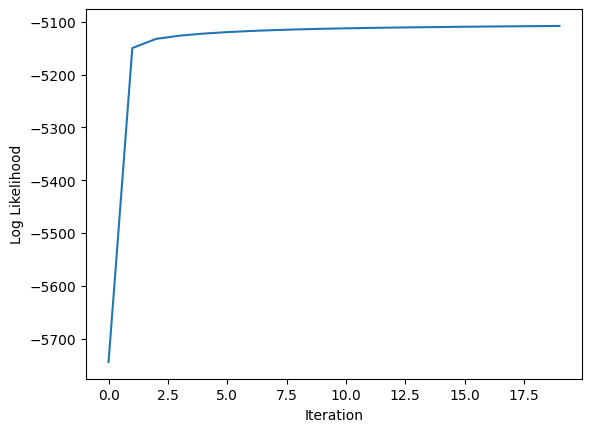

In [82]:
no_update_mu_diagonal_sigma = EM_algorithm_Gaussians_diagonal_matrix(K, A[0], len(m), scipy.stats.lomax(c=1), 20, False)
print(f"Final weights:{no_update_mu_diagonal_sigma[0]}")
print(f"Initial weights: {no_update_mu_diagonal_sigma[1]}")
print(f"Final mean vectors: {no_update_mu_diagonal_sigma[2]}")
print(f"initial g_j: {no_update_mu_diagonal_sigma[3]}")
print(f"final g_j: {no_update_mu_diagonal_sigma[4]}")
# Plot the log likelihood as it is calculated through iterations
plt.plot(no_update_mu_diagonal_sigma[5])
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")

Now, we are ready to run the Independent Metropolis-Hastings algorithm. Again, note that our proposal density is noted as $q(\hatβ) = \sum_{j=1}^{K} \hat w_{j}N(\hatβ|0, \hat g_{i}I_{(m)})$ from the EM algorithm, with estimates $\{\hat w_j, \hat g_j\}_{j=1}^{K}$. Then, we use the transformation $\beta_{m} = (X_{m}^{T}X_{m})^{-\frac{1}{2}}\hat\beta_{m}$ to obtain the estimates of the coefficients.

We hope that these proposed samples matches the priors given below:

$$\beta_{m}|g, m \sim N(0, g(X_{m}^{T}X_{m})^{-1}) , p(g) = (1+g)^{-2}, g > 0$$

So $\pi(x)$, the target density in this example, is the conditional prior distribution of $\beta_{m}$. So for each proposed sample $y$ and current sample $x$ in the MCMC, the acceptance ratio will be:

$$\alpha(x, y) = min (1, \frac{f_{\beta_{m}}(y|m)q_{\beta_{m}}(x)}{f_{\beta_{m}}(x|m)q_{\beta_{m}}(y)} ) = min(1, \frac{f_{\beta_{m}}(y|m)(X_{m}^{T}X_{m})^{-1}q_{\hatβ_{m}}(x)}{f_{\beta_{m}}(x|m)(X_{m}^{T}X_{m})^{-1}q_{\hat\beta_{m}}(y)}= min(1, \frac{f_{\beta_{m}}(y|m) (X^{T}_{m}X_{m})^{-1/2} \sum_{j=1}^{K} \hat w_{j} N(x|0_{m}, \hat g_{j}I_{(m)} )}{f_{\beta_{m}}(x|m) (X^{T}_{m}X_{m})^{-1/2} \sum_{j=1}^{K} \hat w_{j} N(y|0_{m}, \hat g_{j}I_{(m}))})$$

$$ = min(1, \frac{f_{\beta_{m}}(y|m) \sum_{j=1}^{K} \hat w_{j} N(x|0_{m}, \hat g_{j}I_{(m)} )}{f_{\beta_{m}}(x|m) \sum_{j=1}^{K} \hat w_{j} N(y|0_{m}, \hat g_{j}I_{(m}))})$$

2 Things to note:

1. For the target density $\pi(.) = f_{\beta_{m}}( .|m) = \int_{0}^{∞} f(\beta_{m}|m, g)p(g)dg = \int_{0}^{∞} N(0, g(X^{T}_{m}X_{m})^{-1}p(g)dg$, which is the integral of the joint product of the two priors given on the support of $g$ (from $0$ to $∞$). We can approximate this integral by MCMC, where we take $L$ samples, and approximate the density by averaging $L$ products of the multivariate normal density, and the g-prior density. So, $\pi(.) ≈ \frac{1}{L}\sum_{i=1}^{L}N(.|0_{m}, g_{i}(X_{m}^{T}X_{m})^{-1}), g_{i} ∼ p(g) = (1+g)^{-2}$
2. We have expressions for the analytical value of $f(y|m)$ and the expectation of the F-function (which is the conditional distribution of y on m and $\beta_{m}$, or $f(y|m, \beta_{m})$) $E_{q(\beta_{m})} (f(y|m, \beta_{m})$. These  expression are given in the appendix of the paper, as seen [here](https://arxiv.org/pdf/2406.17699#page=52).

Using the form given in the paper, we are trying to estimate $F$ function -- the marginal likelihood of $y$, on $m$ : $f(y|m)$ given by the integral:

$$f(y|m) = ∫f(y|m, β_{m})f(β_{m}|m)dβ_{m} = ∫f(y|m, β_{m})[N(0, g(X_{m}^{T}X_{m})^{-1}p(g)dg]dβ_{m} = ∫(2 \pi σ^{2})^{-\frac{N}{2}}exp[-\frac{1}{2σ_{2}}∑_{i=1}^{N}(y_{i} - x_{i}^{T}β_{m}) ^{2}]N(0, g(X_{m}^{T}X_{m})^{-1})p(g)d\beta_{m}dg = \\ C\int p(g)[\int (2\pi g)^{-\frac{d}{2}}|(X_{m}^{T}X_{m})^{-1}|^{-\frac{1}{2}}exp[\frac{1}{σ_{2}} \sum_{i=1}^{N}y_{i}x_{i}^{T}β_{m}- \frac{1}{2}(\frac{1}{σ^{2}}+\frac{1}{g})β_{m}^{T}(X_{m}^{T}X_{m})β_{m}]dβ_{m}]dg
= \\ C∫(1+\frac{g}{σ^{2}})^{-\frac{d}{2}}exp[\frac{1}{2 σ^{2}}\frac{g}{g+σ^{2}}(\sum_{i=1}^{N}y_{i}x_{i}^{T}(X_{m}^{T}X_{m})^{-1}(\sum_{i=1}^{N}y_{i}x_{i}^{T})^{T}](1+g)^{-2}dg =
\\C∫(1+\frac{g}{\sigma^{2}})^{-\frac{d}{2}}exp[\frac{1}{2 \sigma^{2}} \frac{g}{g + \sigma^{2}}(yX_{m})(X_{m}^{T}X_{m})^{-1}(yX_{m})^{T}](1+g)^{-2}dg $$

for $i = 1,...,N$ observations corresponding to $(x_{i}, y_{i})$

Where $C = (2\pi σ^{2})^{-\frac{N}{2}}exp[-\frac{1}{2σ^{2}} \sum_{i=1}^{N} y_{i}^{2}]$, and $x_{i}$ is the $i$th row of data matrix $X_{m}$.

Since this is a univariate integral, we can explicitly calculate the marginal likelihood

With the proposed variance reduction scheme, we can approximate this integral, with $N$ samples, by calculating its expectation with regards to the target density $\pi(v)$, along with reducing the sampler's variance, by using the sum given from integrating the marginal likelihood $f(y|m, β_{m}$) with respect to the proposal density $q(β_{m})$, with the full results given [here](https://arxiv.org/pdf/2406.17699#page=52):

$$𝔼_{q(β_{m})}(f(y|m, β_{m})) = \int f(y|m, β_{m})q(β_{m})dβ_{m} \\
 = C \sum_{j=1}^{K} w_{j}(1+\frac{g_{j}}{σ^{2}})^{-\frac{p}{2}}exp[\frac{1}{2σ^{2}} \frac{g_{j}}{g_{j}+σ^{2}} (\sum_{i=1}^{N}y_{i}x_{i})^{T} (X_{m}^{T}X_{m})^{-1}(\sum_{i=1}^{N}y_{i}x_{i})^{T}] \\
 = C \sum_{j=1}^{K}w_{j}(1+\frac{g_{j}}{\sigma^{2}})^{-\frac{p}{2}}exp[\frac{1}{2\sigma^{2}}\frac{g}{g+\sigma^{2}}(yX_{m})(X_{m}^{T}X_{m})^{-1}(yX_{m})^{T}]$$


for $j = 1,...,K$ Gaussians used in the proposal density $q(\beta_{m})$ and its g-prior $p(g)$, $(x_{i}, y_{i})_{i=1}^{N}$ generated samples for the original data $(X, y)$, $C = (2\pi σ^{2})^{-\frac{N}{2}}exp[-\frac{1}{2σ^{2}} \sum_{i=1}^{N} y_{i}^{2}]$ the normalizing constant, $σ^{2}$ the scaling factor for the multivariate error term $ϵ \sim N(0, σ^{2}I_{m})$, and $p$ is the dimension of the $\beta_{m}$ or the number of variables selected.

Unlike the previous example, we need to create a separate conditional Markov Chain sampling algorithm for Bayesian linear regression.

In Bayesian literature, there is a Gibbs-sampling algorithms using g-priors for linear regression on the $g$ prior value wich generates the $\beta_{m}$ from its conditional prior on $g$ and $m$ (recall that the prior is $\beta_{m}|g, m \sim N(0, gI_{m})$

Commonly, a prior used for $\sigma^{2}$ in linear regression is the Jeffrey's prior. The Jeffrey's prior is a non-informative prior used for any parameter space. In [Gelman](https://sites.stat.columbia.edu/gelman/book/BDA3.pdf#page=62), the Jeffrey's prior for a parameter $\theta$ is formally defined as the square root of the Fisher information $J(\theta)$ of a distribution:

$$p(\theta) \propto |J(\theta)|^{\frac{1}{2}} = |𝔼((\frac{dlogP(y|\theta)}{d\theta}|θ)^{2})|^{\frac{1}{2}} = |-𝔼(\frac{d^{2}log P(y|\theta)}{d\theta^{2}} )|^{\frac{1}{2}}$$

where $P(y|\theta)$ is the density of the response variable $y$, conditional on $\theta$

Sometimes, a Jeffrey's prior for a distribution is an improper distribution, as is the case for the Jeffrey's prior for $\sigma^{2}$. The Jeffrey's prior on $\sigma^{2}$ for a Gaussian distribution $p(\sigma^{2})$ is proportionate to $\frac{1}{\sigma^{2}}$, which means that the Jeffrey's prior is a uniform prior on the parameter space of $\sigma^{2}$. However, the prior $p(\sigma^{2})$ does not integrate to $1$ over $(0, ∞)$. Hence, Jeffrey's prior is an improper distribution. It is also the limit of an inverse gamma

Nevertheless, the Jeffrey's prior is commonly used because it is a uniform flat prior on $\sigma^{2}$, which is represents no prior knowledge of the distribution of $\sigma^{2}$, and it has a nice conjugate form for the posterior, conditional on $y, X_{m}$, and $g$, which is important because we sample $\sigma^{2}$ from its posterior, instead of its prior.

Using the Jeffrey's prior on $\sigma^{2}$ ($p(σ) \propto \frac{1}{\sigma^{2}}$), we can find the form of the posterior distribution $p(\sigma^{2}|y, X_{m})$. This posterior distribution is an inverse-Gamma, and its full form listed below, from [Hoff](https://sites.math.rutgers.edu/~zeilberg/EM20/Hoff.pdf#page=162)

$$p(\sigma^{2}|y, X_{m}, g) \sim inv-Gamma(\frac{v_{0}+n}{2}, \frac{v_{0}\sigma_{0}^{2} + SSR_{g}}{2}) $$

Where $SSR_{g} = y^{T}(I - \frac{g}{g+1}X_{m}(X_{m}^{T}X_{m})^{-1}X^{T})y$.

So, with the Gibbs sampler algorithm, we sample $β$ and $\sigma^{2}$


One more thing note is the paper's construction of $y \sim N(4X_{3} + 4X_{4}, 2.5^{2})$ implies that the true $β$ is the vector $(0, 0, 4, 4)$

In [83]:
def f_function_y_likelihood(sigma_error, Y_response_vector, X_data_matrix):
  # First to see if dimeinsions match
  # number of rows of X_data_matrix and length of Y_response_vector should match
  if X_data_matrix.shape[0] != len(Y_response_vector):
    warnings.warn("Dimensions of X_data_matrix and Y_response_vector do not match.")
    sys.exit(1)
  # Calculate constant first using logarithms for numerical stability
  ## Find number of samples
  N = len(Y_response_vector)
  ## Find dimension of Gaussians
  d = X_data_matrix.shape[1]
  ## Calculate log constant
  C = (2 * math.pi * (sigma_error ** 2)) ** (-N/2) * math.exp((-1 / (2 * sigma_error ** 2)) * float(np.sum([y ** 2 for y in Y_response_vector])))
  # Numerically integrate
  ## Set up function
  ### Evaluate the summation of y_i x_i^T using a dot product
  yixi = Y_response_vector @ X_data_matrix
  ### inverse of X^TX
  inv_X = np.linalg.inv(X_data_matrix.T @ X_data_matrix)
  ## Time to integrate
  ### Write function within the quad() function call using lambda
  integral_value, error = scipy.integrate.quad(
    lambda g: ((1 + g / (sigma_error ** 2)) ** (-d/2)) * math.exp( (g / (2 * (sigma_error ** 2) * (g + sigma_error ** 2))) * yixi @ inv_X @ yixi.T) * ((1 + g) ** (-2)),
    0, np.inf)
  # Return the constant times the integral
  return C * integral_value

In [84]:
def expectation_f_function_y_likelihood(weights, g_prior_samples, X_data_matrix, Y_response_vector, sigma_error):
  # First check to see dimensions match
  ## Weights and g_prior should have same dimension -- K
  if len(weights) != len(g_prior_samples):
    warnings.warn("Dimensions of weights and g_prior do not match.")
    sys.exit(1)
  ## number of rows of X_data_matrix and length of Y_response_vector should match
  if X_data_matrix.shape[0] != len(Y_response_vector):
    warnings.warn("Dimensions of X_data_matrix and Y_response_vector do not match.")
    sys.exit(1)
  # Calculate the constant first
  ## Find the number of samples
  N = len(Y_response_vector)
  ## Find the dimensions of multivariate normals
  d = X_data_matrix.shape[1]
  ## Calculate the constant
  C = (2 * math.pi * (sigma_error ** 2)) ** (- N / 2) * math.exp((-1 / (2 * sigma_error ** 2)) * float(np.sum([y ** 2 for y in Y_response_vector])))
  # then sum over the K elements (number of mixtures)
  sum = 0
  ## Number of distributions used in mixture (K)
  K = len(weights)
  ## Dimension of the
  for i in range(K):
    g_i = g_prior_samples[i]
    w_i = weights[i]
    sum += w_i * (1 + g_i / (sigma_error** 2)) ** (- d / 2) * math.exp((1 / (2 * sigma_error ** 2)) * (g_i / (g_i + sigma_error ** 2)) *
                                                                (Y_response_vector @ X_data_matrix) @ # Y_i x_i^T summation
                                                                np.linalg.inv(X_data_matrix.T @ X_data_matrix) @ # inverse of product of X^T X
                                                                (Y_response_vector @ X_data_matrix).T) # Transpose of Y_i x_i^T summation
  return C * sum

In [85]:
def linear_regression_pseudo_prior_estimation(z, L, X_data_matrix, g_priors):
  # Check dimensions
  ## Length of z must be the same as the number of columns of X_data_matrix
  if len(z) != X_data_matrix.shape[1]:
    warnings.warn("Dimensions of z and X_data_matrix do not match.")
    sys.exit(1)
  # Solve for (X^TX)^-1 first
  ## Need to generate the g-priors first before feeding it through the function
  covariance_matrix = np.linalg.inv(X_data_matrix.T @ X_data_matrix)
  mean_pdf_calculation = np.mean([scipy.stats.multivariate_normal.pdf(z, mean =  [0 for _ in range(len(z))],
                                                  cov = g_priors[i] * covariance_matrix) for i in range(L)])
  return float(mean_pdf_calculation)

In [86]:
def SSR_g_calculation(g, X, y):
  # Calculate "quadratic" form of X
  quad_X = X @ np.linalg.inv(X.T @ X) @ X.T
  return y.T @ (np.eye(quad_X.shape[0]) - (g / (g+1)) * quad_X) @ y

In [87]:
def conditional_y_on_beta(beta, X, y, sigma):
  # Calculate error first
  error = (y - X @ beta).T @ (y - X @ beta)
  # Constant
  n = X.shape[0]
  constant = 1 / math.sqrt( (2 * math.pi * (sigma ** 2)) ** n)
  return constant * math.exp( (-1/(2 * (sigma ** 2))) * error)

In [88]:
# Selecting columns in X data matrix based on string
def X_data_matrix_from_m(X, m):
  # Shift one left because of Python indices starting at 0
  columns = [(int(i) - 1) for i in m]
  return X[:,columns]

In [89]:
def CMC_gibbs_linear_regression(N_samples, burn_in, X_data_matrix, Y_response_vector, T_iterations, weights_g, g_i_vector):
  # Sanity check: X_data_matrix and Y_response_vector dimensions line up
  if X_data_matrix.shape[0] != len(Y_response_vector):
    warnings.warn("Dimensions of X_data_matrix and Y_response_vector do not match.")
    sys.exit(1)
  # Define N for the posterior of Sigma -- note it is not the same as the N_samples
  N = X_data_matrix.shape[0]
  p = X_data_matrix.shape[1]
  print((N, p))
  mu_MC = []
  g_vector = []
  # Calculate the quadratic inverse of X^T X using Cholesky once
  quad_inverse = np.linalg.inv(X_data_matrix.T @ X_data_matrix)
  for i in range(T_iterations):
    # First pick and fix from gs from mixture of Gaussians
    chosen_g = np.random.choice(a = g_i_vector, p = weights_g)
    g_vector.append(chosen_g)
    # Also calculate the SSR_g first -- this will be needed for sampling of the sigmas
    SSR_g = SSR_g_calculation(chosen_g, X_data_matrix, Y_response_vector)
    # Calculate beta_OLS and g_ratio for beta posterior sampling
    ## Use quad-inverse, since it is (X^{T} * X) ^{-1} * X^{T} y
    beta_OLS = quad_inverse @ X_data_matrix.T @ Y_response_vector
    g_ratio = chosen_g / (chosen_g+1)
    # Initiate beta,sigma, and likelihood list inside each iteration -- need this for likelihood calculation
    beta_list = []
    sigma_2_list = []
    likelihood_list = []
    for j in range(burn_in + N_samples):
      # generate the sigma first
      sigma_2_iteration = scipy.stats.invgamma.rvs(a = N/2, scale = SSR_g/2, size = 1)
      sigma_2_list.append(sigma_2_iteration)
      # generate beta conditional on sigma
      ## using the quad-inverse again for the covariance, since it is g * sigma^{2} * (X^T * X)^{-1}
      beta_iteration = scipy.stats.multivariate_normal.rvs(mean = g_ratio * np.asarray([0 for _ in range(p)]),
                                                           cov = g_ratio * sigma_2_iteration * quad_inverse,
                                                           size = 1)
      beta_list.append(beta_iteration)
      # Calculate joint likelihood of data, conditional on each sigma and beta
      ## Directly calculate using the PDF of multivariate normal
      likelihood_iteration = scipy.stats.multivariate_normal.pdf(Y_response_vector - X_data_matrix @ beta_iteration.T, mean = [0 for _ in range(N)],
                                                                 cov = sigma_2_iteration * np.eye(N))
      likelihood_list.append(float(likelihood_iteration))
    # Throw away burn_in_samples
    beta_list = beta_list[burn_in:]
    sigma_2_list = sigma_2_list[burn_in:]
    likelihood_list = likelihood_list[burn_in:]
    # Calculate the estimator means
    mu_MC_i = np.mean(likelihood_list)
    mu_MC.append(float(mu_MC_i))
  return mu_MC, g_vector

In [90]:

test = CMC_gibbs_linear_regression(1, 0, X_data_matrix_from_m(X, "134"), np.asarray(y), 1000, np.asarray(no_update_mu_diagonal_sigma[0]), np.asarray(no_update_mu_diagonal_sigma[4]))
mu_MC_test = test[0]
mu_MC_test_log10 = [-math.log10(mu_MC_test[i]) for i in range(len(mu_MC_test))]
print(np.mean(mu_MC_test_log10))
print(statistics.variance(mu_MC_test))

(50, 3)
76.58709750541276
3.511217655111673e-134


In [91]:
print(-math.log10(f_function_y_likelihood(2.5, np.asarray(y), X_data_matrix_from_m(X, "123"))))

77.16814464513664


Now, we are ready to initiate the Metropolis-Hastings algorithm for variance reduction. Again, note that the $F$ function is the marginal likelihood of response variable $y$, given the predictors chosen (as denoted as $m$). Hence, $$F(y) = f(y|\beta_{m},X, σ) = (2\pi\sigma^{2})^{-\frac{n}{2}}exp(-\frac{(y-X\beta_{m})^{T}(y-X\beta_{m})}{2\sigma^{2}})$$

$$μ_{IMCV} = \frac{1}{n}\sum_{i=1}^{n}{F(X_{i}) + α(X_{i}, Y_{i})(F(Y_{i})-F(X_{i})) - (F(Y_{i}) - 𝔼_{q}(F(Y_{i})))}$$

In [92]:
def multivariate_linear_regression_metropolis(K, N_samples, T_iterations,
                                              weights, g_j_hat, m, g_prior_function, X_data_matrix, Y_response_vector,
                                              L, sigma_error):
  # Sanity checks: make sure K, length of weights, and length of g_j_hat is the same
  if len(weights) != len(g_j_hat) or len(weights) != K:
    warnings.warn("Dimensions of weights, g_i, and K do not match.")
    sys.exit(1)
  # Make sure dimension of m, and columns of X_data_matrix are the same
  if len(m) != X_data_matrix.shape[1]:
    warnings.warn("Dimensions of m and X_data_matrix do not match.")
    sys.exit(1)
  # reassign length of m to P if this passes.. issues with len(m) not acting right
  p = X_data_matrix.shape[1]
  # Check dimensions of the betas(given by m), and the Sigma covariance matrices
  # Initiate the IMCV and MC mean list
  mu_IMCV_list = []
  mu_MC_list = []
  # Initialize the beta-hat-transformation constant. Needed to transform samples generated from EM mixture to beta
  beta_hat_operator = scipy.linalg.fractional_matrix_power(X_data_matrix.T @ X_data_matrix, -1/2)
  for i in range(T_iterations):
    # Initiate X chain, Y chain, and alpha chain
    ## X is current state
    ## Y is proposed state
    ## Alpha chain is the ratio of the pdfs to see if the sample should be accepted: we will also generate uniform RV for acceptance calculation
    X_chain = []
    Y_chain = []
    alpha_chain = []
    for j in range(N_samples):
      # edge case: X is empty
      if len(X_chain) == 0:
        # Accept proposed samples from mixed EM Gaussian mixture with probability 1
        # Sample from mixture first, and then draw from the chosen distribution
        chosen_g = np.random.choice(a = g_j_hat, p = weights)
        Y_i = scipy.stats.multivariate_normal.rvs(mean = [0 for _ in range(p)], cov = chosen_g * np.identity(p))
        ### Transform sample
        Y_i = np.dot(beta_hat_operator, Y_i)
        ### Append to X_chain
        X_chain.append(np.asarray(Y_i))
        ### Append to Y_chain
        Y_chain.append(np.asarray(Y_i))
        ### Append to Alpha Chain
        alpha_chain.append(1)
      else:
        # Simulate Y_i first and perform transformation
        ## Sample g from mixture of gaussians, and then sample from that distribution
        chosen_g = np.random.choice(a = g_j_hat, p = weights)
        Y_i = scipy.stats.multivariate_normal.rvs(mean = [0 for _ in range(p)], cov = chosen_g * np.identity(p))
        Y_i = np.dot(beta_hat_operator, Y_i)
        # Append to proposal chain and get current state(X_i)
        Y_chain.append(np.asarray(Y_i))
        X_i = X_chain[-1]
        # Calculate pseudo-prior for acceptance/rejection sampling
        ## Note that I sample the g-priors first, to ensure that both the pseudo-prior for X_i and Y_i are calculated from the same sets of g-priors
        g_priors_for_pseudo_prior = scipy.stats.lomax(c = 1).rvs(size = L)
        alpha_i_numerator = (linear_regression_pseudo_prior_estimation(Y_i, L, X_data_matrix, g_priors_for_pseudo_prior) *
                   np.dot(weights, [scipy.stats.multivariate_normal.pdf(x = X_i, mean = [0 for _ in range(p)], cov = g_i * scipy.linalg.inv(X_data_matrix.T @ X_data_matrix)) for g_i in g_j_hat]))
        alpha_i_denominator = (linear_regression_pseudo_prior_estimation(X_i, L, X_data_matrix, g_priors_for_pseudo_prior) *
                   np.dot(weights, [scipy.stats.multivariate_normal.pdf(x = Y_i, mean = [0 for _ in range(p)], cov = g_i * scipy.linalg.inv(X_data_matrix.T @ X_data_matrix)) for g_i in g_j_hat]))
        alpha_i = min(1, alpha_i_numerator/alpha_i_denominator)
        alpha_chain.append(alpha_i)
        # acceptance rejection
        U = np.random.uniform()
        if U < alpha_i:
          X_chain.append(np.asarray(Y_i))
        else:
          X_chain.append(np.asarray(X_i))
    # Calculate the estimator means
    ## Returning the same values for all of the terms here. Big issue with this function. Need some dependence of F function (marginal likelihood of model) on current states
    ## Y and X
    mu_MC_i = np.mean([conditional_y_on_beta(X_chain[i], X_data_matrix, Y_response_vector, sigma_error) for i in range(len(X_chain))])
    mu_MC_list.append(float(mu_MC_i))
    ### Perhaps we induce dependence on the current states of the chains (X,Y) by sampling sigma (like a Gibbs sampler)?
    mu_IMCV_i = np.mean([conditional_y_on_beta(X_chain[i], X_data_matrix, Y_response_vector, sigma_error) +
        alpha_chain[i] * (conditional_y_on_beta(Y_chain[i], X_data_matrix, Y_response_vector, sigma_error) - conditional_y_on_beta(X_chain[i], X_data_matrix, Y_response_vector, sigma_error))
        - (conditional_y_on_beta(Y_chain[i], X_data_matrix, Y_response_vector, sigma_error) - expectation_f_function_y_likelihood(weights, g_j_hat, X_data_matrix, Y_response_vector, sigma_error))
    for i in range(len(Y_chain))])
    mu_IMCV_list.append(float(mu_IMCV_i))
  return mu_MC_list, mu_IMCV_list

In [93]:
# Sanity check here
sample = X_data_matrix_from_m(X, m = "123")

m = "123"
print([0 for _ in range(len(m))])
chosen_g = np.random.choice(a = np.array(no_update_mu_diagonal_sigma[4]), p = np.array(no_update_mu_diagonal_sigma[0]))
print(no_update_mu_diagonal_sigma[4] @ no_update_mu_diagonal_sigma[0])
print([float(scipy.stats.invgamma.rvs(a = 1/2, scale = 1/2)) for i in range(2)])
sample.shape[0]

[0, 0, 0]
7.115488454353405
[2.8966020021725547, 160.53845704638007]


50

In [94]:
# Continuing the m = "123" example as a sample test to see if our code works -- trying to recover the numbers from the paper
test_run = multivariate_linear_regression_metropolis(4, 50, 50, np.asarray(no_update_mu_diagonal_sigma[0]).ravel(), np.asarray(no_update_mu_diagonal_sigma[4]).ravel(),
                                                     "123", scipy.stats.lomax(c=1), X_data_matrix_from_m(X, m = "123"), y, 100, 2.5)

In [103]:
mu_IMCV_test = test_run[1]
mu_IMCV_test_log10 = [-math.log10(mu_IMCV_test[i]) for i in range(len(mu_IMCV_test))]
print(np.mean([-math.log10(mu_IMCV_test[i]) for i in range(len(mu_IMCV_test))]))
print(np.mean([-math.log10(mu_MC_test[i]) for i in range(len(mu_MC_test))]))

76.77042445667193
76.58709750541276


For the CMC estimator, we actually don't use the Gibbs sampler. Instead, we sample directly from $\pi(x)$. So below I will create a symmetric Metropolis sampler to sample dependent samples from $\pi(x)$

In [96]:
def symmetric_metro_betas(y, X_data_matrix, T_iterations, n_samples, F_function,  g_prior, m, burn_in):
  # Check to see if pi_distribution, and g_prior can be sampled from
  for name, dist in [("g_prior", g_prior)]:
    if not all(hasattr(dist, attr) for attr in ["rvs", "pdf", "expect"]):
        raise ValueError(
            f"{name} must be a valid frozen scipy.stats distribution with .rvs(), .pdf(), and .expect(). Got: {type(dist)}"
        )
  mu_MC = []
  # Calculate dimension of model -- needed for sampling of beta from multivariate normal
  n = len(m)
  # Calculate inverse quad of X data matrix
  X_inverse = np.linalg.inv(X_data_matrix.T @ X_data_matrix)
  for i in range(T_iterations):
    X_chain = []
    for j in range(n_samples):
      if len(X_chain) == 0:
        # Accept with probability of 1
        ## Sample g prior first
        g_i = float(g_prior.rvs())
        ## Then sample beta
        Y_i = scipy.stats.multivariate_normal.rvs(mean = [0 for _ in range(n)],
                                                cov = g_i * X_inverse, size = 1)
        X_chain.append(Y_i)
      else:
        X_i = X_chain[-1]
        g_i = float(g_prior.rvs())
        Y_i = scipy.stats.multivariate_normal.rvs(mean = [0 for _ in range(n)],
                                              cov = g_i * X_inverse, size = 1)
        # Acceptance-rejection
        acceptance_denominator = scipy.stats.multivariate_normal.logpdf(X_i, mean = [0 for _ in range(n)], cov = g_i * X_inverse)
        acceptance_numerator = scipy.stats.multivariate_normal.logpdf(Y_i, mean = [0 for _ in range(n)], cov = g_i * X_inverse)
        log_diff = acceptance_numerator - acceptance_denominator
        U = float(np.random.uniform(0, 1))
        ## Adding some numerical stability fixes to the acceptance/rejection process
        if log_diff > 0:
          # Accept with probability of 1
          ## If log_diff > 0, then min(1, fraction of acceptance) becomes 1
          X_chain.append(Y_i)
        else:
          # Calculate the acceptance/rejection probability
          alpha_i = math.exp(log_diff)
          if U < alpha_i:
            X_chain.append(Y_i)
          else:
            X_chain.append(X_i)
    # Toss out burn_in_samples
    X_chain = X_chain[burn_in:]
    mu_MC_i = np.mean([F_function(X_chain[i]) for i in range(len(X_chain))])
    mu_MC.append(float(mu_MC_i))
  return mu_MC

In [99]:
test_run_MC = symmetric_metro_betas(np.asarray(y), X_data_matrix_from_m(X, m = "123"), 50, 50,
                                    F_function = lambda x: conditional_y_on_beta(x, X_data_matrix_from_m(X, m = "123"), np.asarray(y), 2.5),
                                    g_prior = scipy.stats.lomax(c=1), m = "123", burn_in = 0)

In [104]:
test_run_MC_log10 = [-math.log10(test_run_MC[i]) for i in range(len(test_run_MC))]
print(np.mean(test_run_MC_log10))

99.72014579387807
106677.538432929
